In [ ]:
%pip install langgraph graphviz langchain langchain_ollama --q

In [7]:
# import networkx as nx
# import matplotlib.pyplot as plt

from typing import TypedDict, Optional
from langchain.chat_models import ChatOpenAI
from langchain_ollama import OllamaLLM
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
import json
import re
from typing_extensions import Annotated

In [8]:
llm = OllamaLLM(model="llama3.2", base_url="http://localhost:11434")

In [9]:
# # Step 1: Define the State Schema
class PrototypeState(TypedDict):
    input_requirements: Annotated[str, "single"]
    frontend_spec: Annotated[Optional[str], "multi"]
    backend_spec: Annotated[Optional[str], "multi"]
    frontend_code: Annotated[Optional[str], "multi"]
    backend_code: Annotated[Optional[str], "multi"]
    frontend_valid: Annotated[bool, "multi"]
    backend_valid: Annotated[bool, "multi"]
    frontend_feedback: Annotated[Optional[str], "multi"]
    backend_feedback: Annotated[Optional[str], "multi"]
    frontend_attempts: Annotated[int, "multi"]  # Tracks frontend iterations
    backend_attempts: Annotated[int, "multi"]  # Tracks backend iterations
    deployment_ready: Annotated[bool, "multi"]


def extract_section(text: str, section: str) -> str:
    """Extracts frontend/backend sections from LLM response using regex."""
    pattern = rf"{section}.*?:\s*(.*?)(?=\n\n|$)"  # Matches until next blank line or end
    match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
    return match.group(1).strip() if match else f"Error extracting {section} specifications."

def frontend_requirement_agent(state: PrototypeState) -> PrototypeState:
    """Extracts frontend-specific requirements manually (without JSON)."""
    prompt = f"""
    You are a software architect. Extract only the FRONTEND specifications from the given project requirements.

    **Ensure your response follows this format:**
    Frontend Specifications:
    - Item 1
    - Item 2
    - ...

    **Project Requirements:** {state['input_requirements']}
    """
    
    response = llm.invoke(prompt)
    frontend_spec = extract_section(response, "Frontend Specifications")
    
    return {"frontend_spec": frontend_spec}

def backend_requirement_agent(state: PrototypeState) -> PrototypeState:
    """Extracts backend-specific requirements manually (without JSON)."""
    prompt = f"""
    You are a software architect. Extract only the BACKEND specifications from the given project requirements.

    **Ensure your response follows this format:**
    Backend Specifications:
    - Item 1
    - Item 2
    - ...

    **Project Requirements:** {state['input_requirements']}
    """
    
    response = llm.invoke(prompt)
    backend_spec = extract_section(response, "Backend Specifications")
    
    return {"backend_spec": backend_spec}

# Step 3: Development & Validation Agents (Same as before)
def frontend_agent(state: PrototypeState) -> PrototypeState:
    """Generates frontend code based on specifications using LLM."""
    prompt = f"""
    You are a frontend developer. Write a clean, modular frontend component based on the following specifications:
    
    {state['frontend_spec']}
    
    Ensure the code follows best practices.
    """
    return {"frontend_code": llm.invoke(prompt)}

def backend_agent(state: PrototypeState) -> PrototypeState:
    """Generates backend code based on specifications using LLM."""
    prompt = f"""
    You are a backend developer. Write a clean, modular backend API or service based on the following specifications:
    
    {state['backend_spec']}
    
    Ensure the code is scalable and follows best practices.
    """
    return {"backend_code": llm.invoke(prompt)}

def frontend_validation_agent(state: PrototypeState) -> PrototypeState:
    """Validates frontend code using LLM with stricter validation handling."""
    prompt = f"""
    You are a senior frontend developer. Validate the following frontend code:

    {state['frontend_code']}

    **Response Format:**
    - If the code is correct, return exactly: "Valid Frontend Code."
    - If the code is incorrect, return: "Invalid Frontend Code: [detailed explanation]".

    **Your response should be in one of the two formats only. Do not include extra text.**
    """
    
    response = llm.invoke(prompt).strip()  # Remove extra whitespace

    # Ensure we only mark valid if response is exactly "Valid Frontend Code."
    frontend_valid = response.strip() == "Valid Frontend Code."

    return {
        "frontend_valid": frontend_valid,
        "frontend_feedback": response
    }

def backend_validation_agent(state: PrototypeState) -> PrototypeState:
    """Validates backend code using LLM with stricter validation handling."""
    prompt = f"""
    You are a senior backend developer. Validate the following backend code:

    {state['backend_code']}

    **Response Format:**
    - If the code is correct, return exactly: "Valid Backend Code."
    - If the code is incorrect, return: "Invalid Backend Code: [detailed explanation]".

    **Your response should be in one of the two formats only. Do not include extra text.**
    """
    
    response = llm.invoke(prompt).strip()  # Remove extra whitespace

    backend_valid = response.strip() == "Valid Backend Code."

    return {
        "backend_valid": backend_valid,
        "backend_feedback": response
    }


In [10]:
graph = StateGraph(PrototypeState)

# Add nodes (Split requirement agent into two)
graph.add_node("frontend_requirement_agent", frontend_requirement_agent)
graph.add_node("backend_requirement_agent", backend_requirement_agent)
graph.add_node("frontend_agent", frontend_agent)
graph.add_node("backend_agent", backend_agent)
graph.add_node("frontend_validation_agent", frontend_validation_agent)
graph.add_node("backend_validation_agent", backend_validation_agent)

# # Define edges (Frontend and Backend run independently)
graph.add_edge(START, "frontend_requirement_agent")
graph.add_edge(START, "backend_requirement_agent")
graph.add_edge("frontend_requirement_agent", "frontend_agent")
graph.add_edge("backend_requirement_agent", "backend_agent")
graph.add_edge("frontend_agent", "frontend_validation_agent")
graph.add_edge("backend_agent", "backend_validation_agent")

# Step 5: Prevent Infinite Loops with Limits
MAX_ATTEMPTS = 3  # Define max iterations per agent

def frontend_iteration(state: PrototypeState):
    if state['frontend_valid']:
        return END  # Stop if valid
    
    state['frontend_attempts'] += 1
    if state['frontend_attempts'] >= MAX_ATTEMPTS:
        print("⚠️ Frontend validation failed too many times. Stopping...")
        return END  # Stop looping after max attempts
    return "frontend_agent"  # Retry frontend generation

def backend_iteration(state: PrototypeState):
    if state['backend_valid']:
        return END  # Stop if valid
    
    state['backend_attempts'] += 1
    if state['backend_attempts'] >= MAX_ATTEMPTS:
        print("⚠️ Backend validation failed too many times. Stopping...")
        return END  # Stop looping after max attempts
    return "backend_agent"  # Retry backend generation

graph.add_conditional_edges("frontend_validation_agent", frontend_iteration)
graph.add_conditional_edges("backend_validation_agent", backend_iteration)

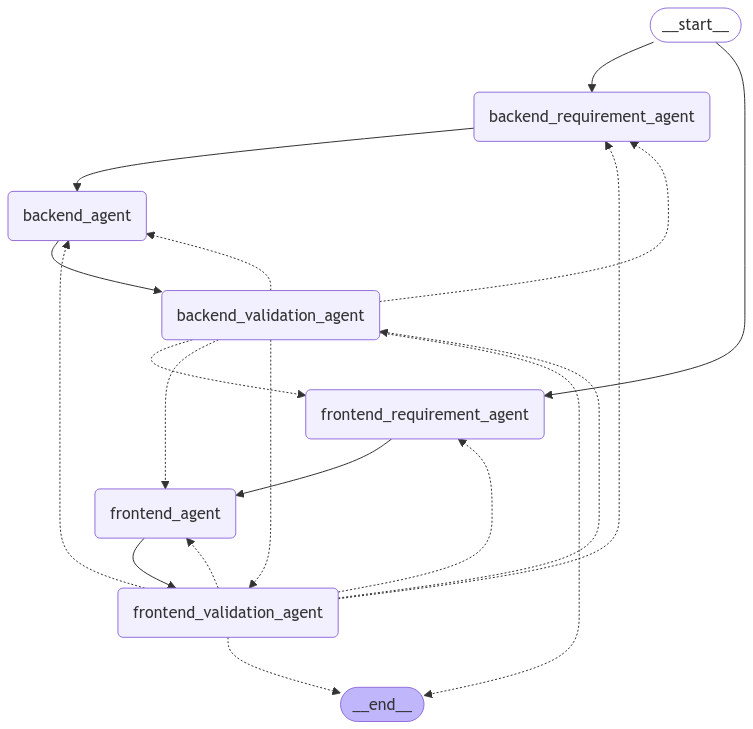

In [11]:
from IPython.display import Image

compiled_graph = graph.compile()
Image(compiled_graph.get_graph().draw_mermaid_png())

In [12]:
# Initial state with input requirements
initial_state = PrototypeState(
    input_requirements="A web application that allows users to register and view a dashboard with their profile details.",
    frontend_spec=None,
    backend_spec=None,
    frontend_code=None,
    backend_code=None,
    frontend_valid=False,
    backend_valid=False,
    frontend_feedback=None,
    backend_feedback=None,
    frontend_attempts=0,  # Initialize attempt counters
    backend_attempts=0
)

# Execute the graph
final_state = compiled_graph.invoke(initial_state, {"recursion_limit": 50})

In [13]:
import pprint
pprint.pprint(final_state)

{'backend_attempts': 0,
 'backend_code': '**User Service API**\n'
                 '\n'
                 'Below is an example of a scalable and maintainable User '
                 'Service API written in Node.js using Express.js, MongoDB, '
                 'and Passport.js.\n'
                 '\n'
                 '### Project Structure\n'
                 '\n'
                 '```bash\n'
                 'user-service/\n'
                 'app.js\n'
                 'config/\n'
                 'database.js\n'
                 'passport.js\n'
                 'models/\n'
                 'User.js\n'
                 'routes/\n'
                 'auth.js\n'
                 'users.js\n'
                 'services/\n'
                 'user.service.js\n'
                 'utils/\n'
                 'auth.utils.js\n'
                 'index.js\n'
                 '```\n'
                 '\n'
                 '### Database Configuration (config/database.js)\n'
                 '\n'
 